In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

file_path = './amazon_user_reviews.parquet'

df = pd.read_parquet(file_path)

In [2]:
from collections import Counter
Counter(df["rating"])

Counter({5.0: 11212, 4.0: 2750, 3.0: 1268, 1.0: 1064, 2.0: 655})

In [3]:
full_col = ["rating"] + ["text_cleaned"]
full_df = df[full_col]
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16949 entries, 0 to 16948
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating        16949 non-null  float64
 1   text_cleaned  16949 non-null  object 
dtypes: float64(1), object(1)
memory usage: 265.0+ KB


In [4]:
full_df.to_parquet('amazon_user_reviews_DL.parquet', index=False)

## "text_features" copy from Basic&Textual_EDA

In [5]:
# Basic length features
df['char_count'] = df['original_text'].str.len()
df['word_count'] = df['original_text'].str.split().str.len()
df['avg_word_length'] = df['char_count'] / df['word_count']

# Punctuation
df['exclamation_count'] = df['original_text'].str.count('!')
df['question_count'] = df['original_text'].str.count('\?')
df['period_count'] = df['original_text'].str.count('\.')
df['comma_count'] = df['original_text'].str.count(',')
df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')
df['total_punctuation'] = (df['exclamation_count'] + df['question_count'] +
                            df['period_count'] + df['comma_count'])

# Capitalization features
df['all_caps_words'] = df['original_text'].str.findall(r'\b[A-Z]{2,}\b').str.len()
df['uppercase_count'] = df['original_text'].str.findall(r'[A-Z]').str.len()
df['uppercase_ratio'] = df['uppercase_count'] / df['char_count']

# Binary indicators
df['has_exclamation'] = (df['exclamation_count'] > 0).astype(int)
df['has_question'] = (df['question_count'] > 0).astype(int)
df['has_all_caps'] = (df['all_caps_words'] > 0).astype(int)

text_features = ['exclamation_count', 'question_count', 'word_count',
                 'char_count', 'all_caps_words', 'uppercase_ratio',
                 'total_punctuation', 'avg_word_length']

<>:8: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_25283/1649078473.py:8: SyntaxWarning: invalid escape sequence '\?'
  df['question_count'] = df['original_text'].str.count('\?')
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_25283/1649078473.py:9: SyntaxWarning: invalid escape sequence '\.'
  df['period_count'] = df['original_text'].str.count('\.')
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_25283/1649078473.py:11: SyntaxWarning: invalid escape sequence '\.'
  df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')


## "Other_features": "helpful_vote","int_verified_purchase","hour", "month", "season"

In [6]:
# 1. DATA-PREPROCESSING

# Convert verified_purchase to integer (0: False/1: True)
df["int_verified_purchase"]= df['verified_purchase'].astype(int)

# Parse `datetime` and extract hour, month, season
# Nominal Season: 1:Spring (March–May), 2:Summer (June–August), 3:Fall (September–November), and 4:Winter (December–February). 

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
# hour: integer hour from datetime
df['hour'] = df['datetime'].dt.hour
# month: integer month (1-12)
df['month'] = df['datetime'].dt.month
# season mapping based on month
def month_to_season(m):
    if m in [3,4,5]:
        return 1
    elif m in [6,7,8]:
        return 2
    elif m in [9,10,11]:
        return 3
    elif m in [12,1,2]:
        return 4
    else:
        return None
df['season'] = df['month'].apply(month_to_season)

In [7]:
other_features =["helpful_vote","int_verified_purchase","hour", "month", "season"]
features = text_features + other_features

In [8]:
# 2. mean, median, std analysis
analysis_by_rating = df.groupby('rating')[other_features].agg(['mean', 'median', 'std'])
print("\n", analysis_by_rating.round(2))


        helpful_vote               int_verified_purchase                hour  \
               mean median    std                  mean median   std   mean   
rating                                                                        
1.0            4.02    0.0  21.39                  0.84    1.0  0.37  12.84   
2.0            2.64    0.0  15.69                  0.78    1.0  0.41  13.14   
3.0            1.77    0.0  12.85                  0.68    1.0  0.47  12.85   
4.0            1.44    0.0   6.53                  0.54    1.0  0.50  13.22   
5.0            1.53    0.0  12.66                  0.74    1.0  0.44  13.03   

                    month              season               
       median   std  mean median   std   mean median   std  
rating                                                      
1.0      15.0  7.78  6.52    6.5  3.43   2.47    2.0  1.12  
2.0      15.0  7.57  6.52    7.0  3.42   2.51    2.0  1.09  
3.0      15.0  7.75  6.50    7.0  3.54   2.53    3.0  1.13  

In [9]:
# 3. CORRELATION WITH RATING
print("Other features: CORRELATION WITH RATING")

# Calculate correlation of each feature with rating
correlations = df[other_features + ['rating']].corr()['rating'].sort_values(ascending=False)
print("\n", correlations)

Other features: CORRELATION WITH RATING

 rating                   1.000000
season                   0.028087
hour                     0.004002
month                   -0.004608
int_verified_purchase   -0.016005
helpful_vote            -0.042684
Name: rating, dtype: float64


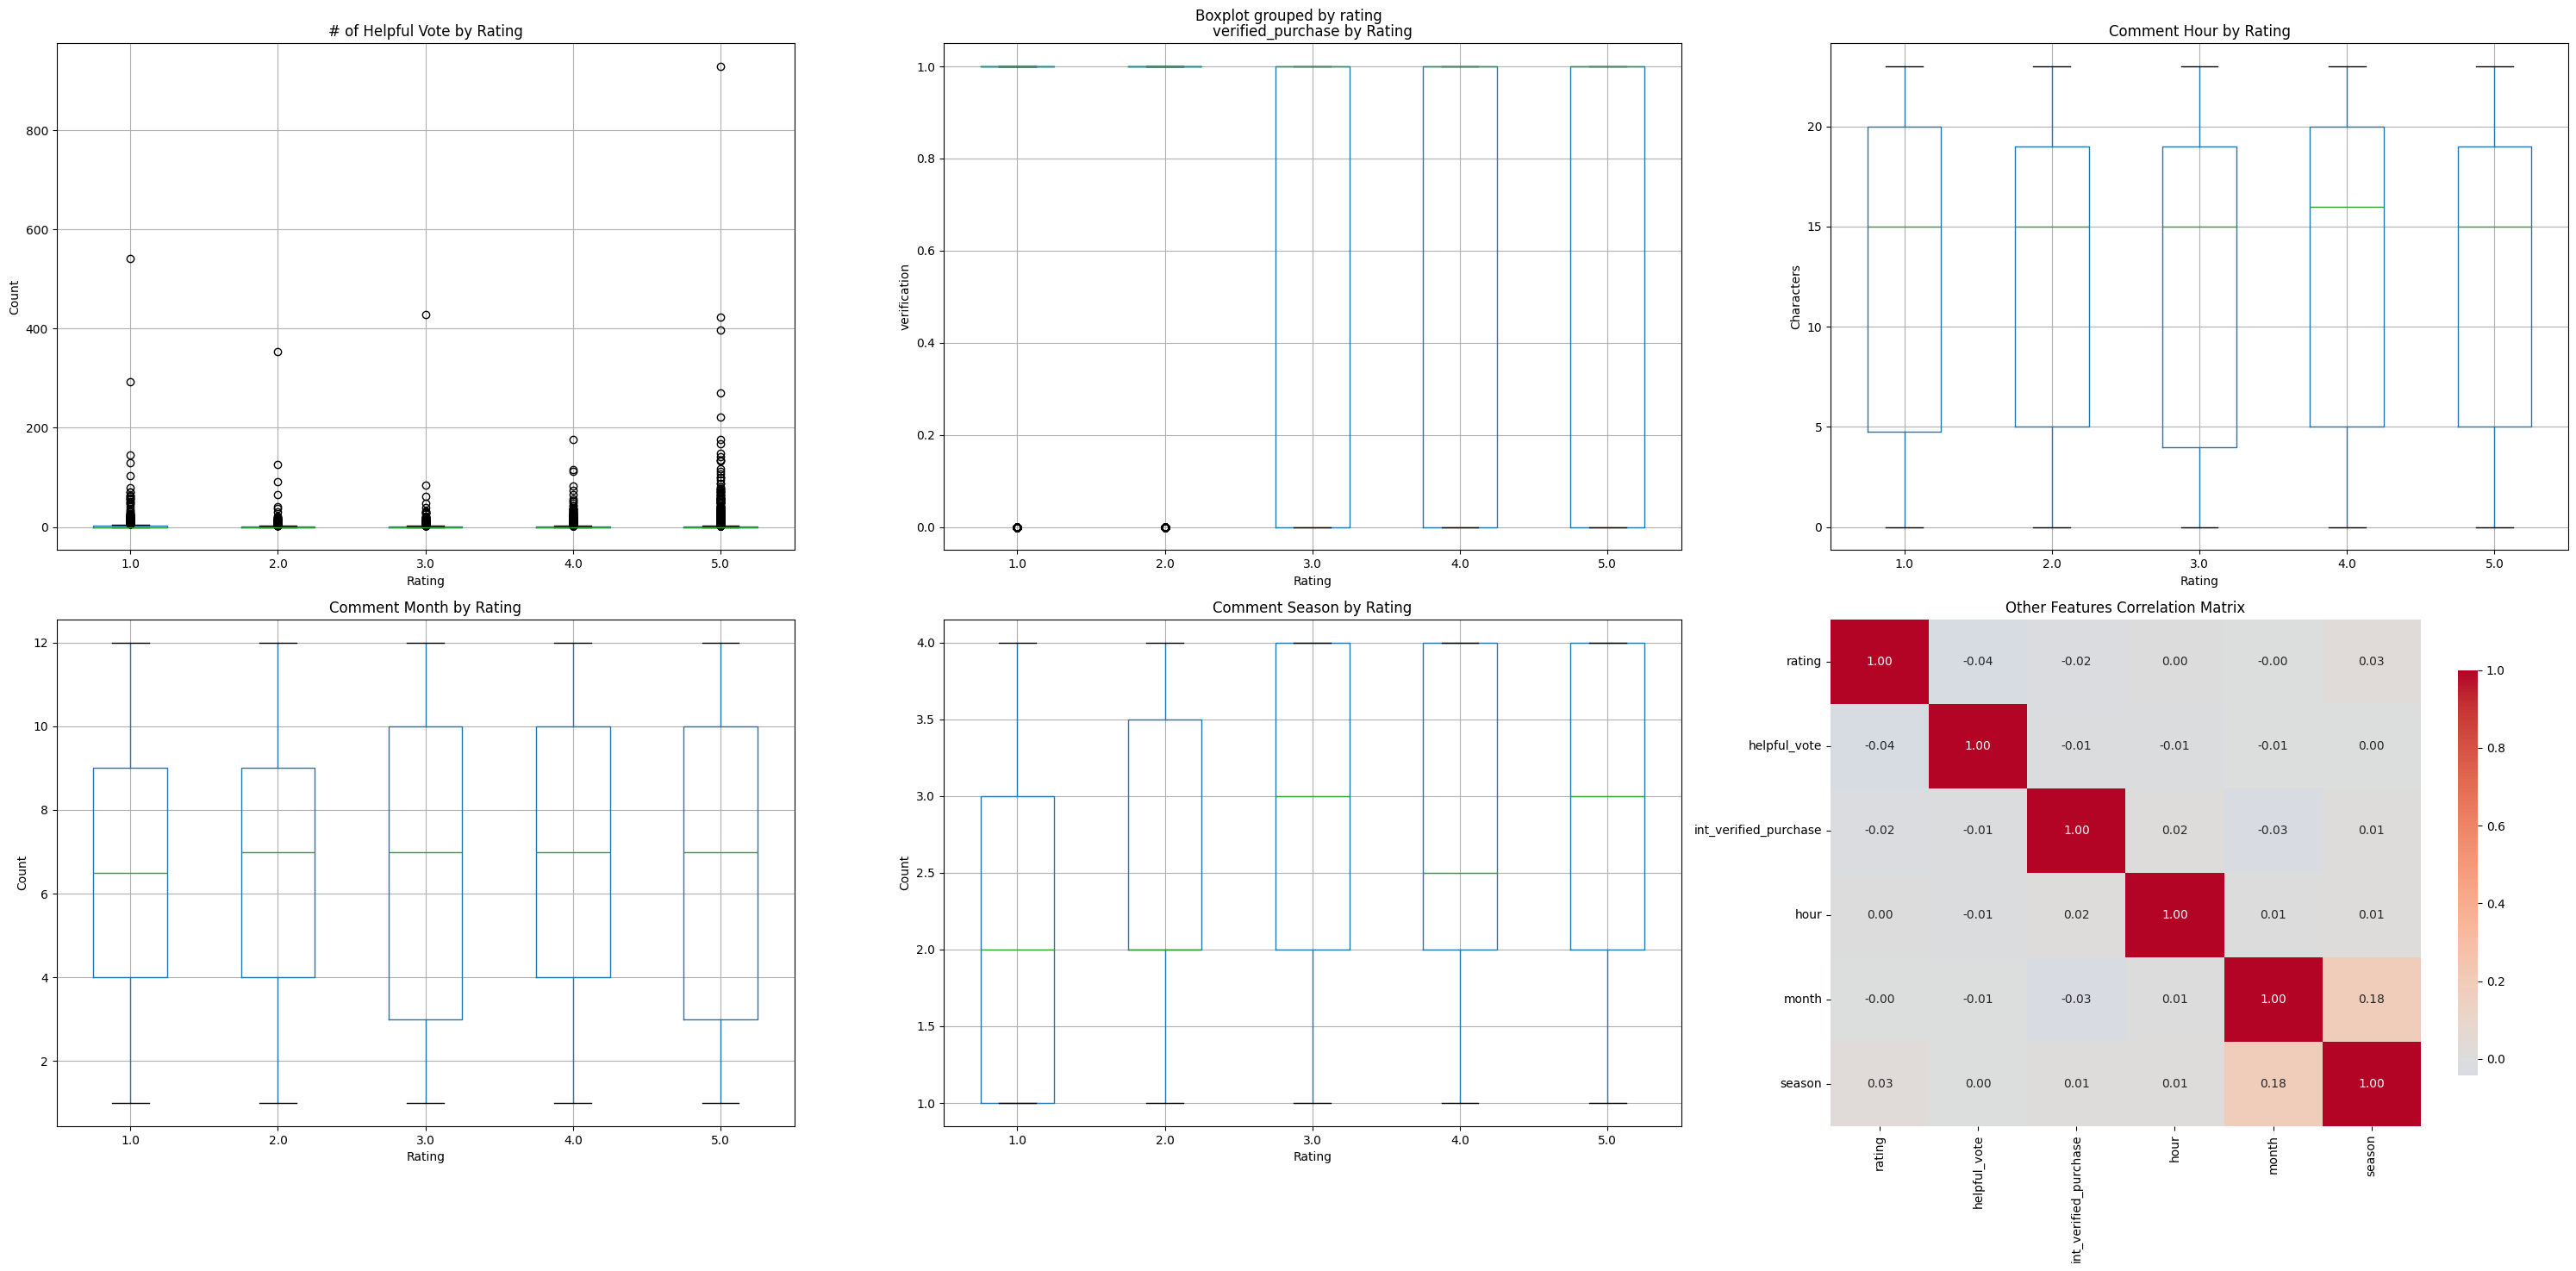

In [10]:
# PART 4: VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(30, 15))
fig.suptitle('Other features Analysis by Rating', fontsize=16, fontweight='bold')

# 1. helpful_vote
df.boxplot(column='helpful_vote', by='rating', ax=axes[0, 0])
axes[0, 0].set_title('# of Helpful Vote by Rating')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# 2. int_verified_purchase
df.boxplot(column='int_verified_purchase', by='rating', ax=axes[0, 1])
axes[0, 1].set_title('verified_purchase by Rating')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('verification')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# 3. Comment hour
df.boxplot(column='hour', by='rating', ax=axes[0, 2])
axes[0, 2].set_title('Comment Hour by Rating')
axes[0, 2].set_xlabel('Rating')
axes[0, 2].set_ylabel('Characters')
plt.sca(axes[0, 2])
plt.xticks(rotation=0)

# 4. Comment month
df.boxplot(column='month', by='rating', ax=axes[1, 0])
axes[1, 0].set_title('Comment Month by Rating')
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Count')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 5. Comment season
df.boxplot(column='season', by='rating', ax=axes[1, 1])
axes[1, 1].set_title('Comment Season by Rating')
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_ylabel('Count')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

# 9. Correlation heatmap
corr_features = ["rating","helpful_vote","int_verified_purchase","hour", "month", "season"]
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1, 2], cbar_kws={'shrink': 0.8})
axes[1, 2].set_title('Other Features Correlation Matrix')
plt.tight_layout()
# plt.savefig("other_features_analysis1.png")
plt.show()

In [11]:
# 5. Check for multicollinearity
print("\nother_features MULTICOLLINEARITY CHECK")
print("-" * 80)
high_corr_pairs = []
for i in range(len(other_features)):
    for j in range(i+1, len(other_features)):
        corr_val = df[other_features[i]].corr(df[other_features[j]])
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((other_features[i], other_features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.8)")



other_features MULTICOLLINEARITY CHECK
--------------------------------------------------------------------------------
No highly correlated features found (threshold: 0.8)


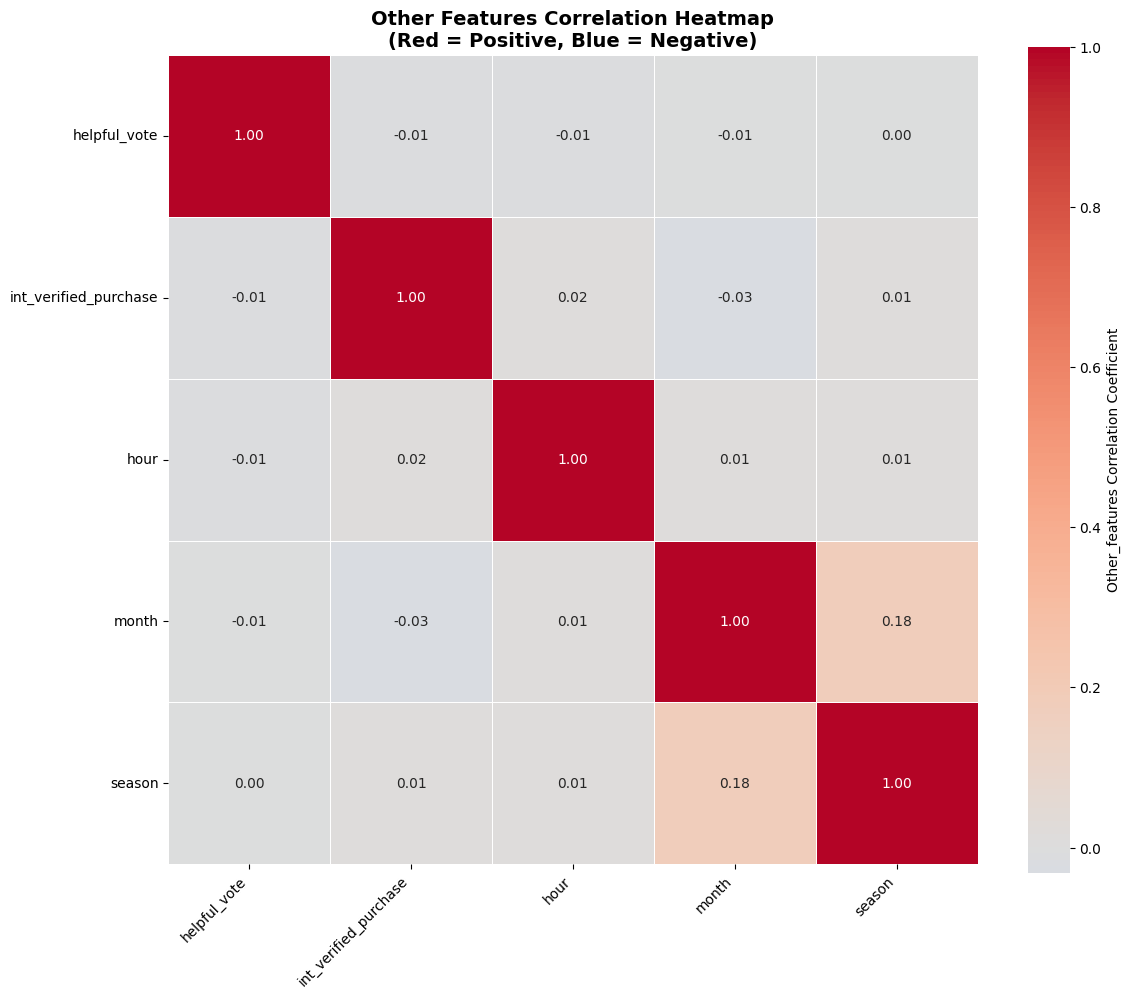

In [12]:
#6.  CORRELATION MATRIX BETWEEN OTHER_FEATURES

corr_matrix = df[other_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'Other_features Correlation Coefficient'})

plt.title('Other Features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the file
# plt.savefig("multicolinarity_heatmap_other_features.png", dpi=300, bbox_inches='tight')
plt.show()

# “features": "text_features" + "other_features"

In [13]:
# 1. CORRELATION WITH RATING

print("ALl featrues: CORRELATION WITH RATING")

# Calculate correlation of each feature with rating
correlations = df[features + ['rating']].corr()['rating'].sort_values(ascending=False)
print("\n", correlations)

ALl featrues: CORRELATION WITH RATING

 rating                   1.000000
avg_word_length          0.044129
exclamation_count        0.040752
season                   0.028087
uppercase_ratio          0.004856
hour                     0.004002
month                   -0.004608
int_verified_purchase   -0.016005
all_caps_words          -0.024566
char_count              -0.035824
word_count              -0.039700
helpful_vote            -0.042684
total_punctuation       -0.043211
question_count          -0.047880
Name: rating, dtype: float64


In [14]:
# 2.1. Check for multicollinearity by threshold = 0.8
print("All MULTICOLLINEARITY CHECK, threshold = 0.8")
print("-" * 80)
high_corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_val = df[features[i]].corr(df[features[j]])
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((features[i], features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.8)")


All MULTICOLLINEARITY CHECK, threshold = 0.8
--------------------------------------------------------------------------------
Highly correlated feature pairs (>0.8):
  - word_count <-> char_count: 0.997
  - word_count <-> total_punctuation: 0.928
  - char_count <-> total_punctuation: 0.931

Recommendation: Keep only one feature from each highly correlated pair


In [15]:
# 2.2.  Check for multicollinearity - The Percentile Approach (Distribution-Based) - calculate new threshold

# Calculate the absolute correlation matrix
corr_matrix = df[features].corr().abs()

# Extract only the upper triangle (to avoid self-correlation and duplicates)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
all_corrs = upper_tri.stack().values

# Dynamically set threshold at the 95th percentile
dynamic_threshold = np.percentile(all_corrs, 95)
print(f"Suggested threshold based on data distribution: {dynamic_threshold:.3f}")


Suggested threshold based on data distribution: 0.380


In [16]:
# 2.2.  Check for multicollinearity - The Percentile Approach (Distribution-Based), threshold = 0.380
print("All MULTICOLLINEARITY CHECK, threshold = 0.380")
print("-" * 80)
high_corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_val = df[features[i]].corr(df[features[j]])
        if abs(corr_val) > 0.380:
            high_corr_pairs.append((features[i], features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.380):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.380)")


All MULTICOLLINEARITY CHECK, threshold = 0.380
--------------------------------------------------------------------------------
Highly correlated feature pairs (>0.380):
  - word_count <-> char_count: 0.997
  - word_count <-> total_punctuation: 0.928
  - word_count <-> int_verified_purchase: -0.385
  - char_count <-> total_punctuation: 0.931

Recommendation: Keep only one feature from each highly correlated pair


In [17]:
# 2.3.  Check for multicollinearity - VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    # Ensure data is numeric and handle missing values
    X = df[features].dropna()
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]
    
    return vif_data.sort_values(by="VIF", ascending=False)

# 1. Calculate all VIF scores
vif_results = calculate_vif(df, features)

# 2. Filter and print only features with VIF > 5
high_vif = vif_results[vif_results["VIF"] > 5]

if not high_vif.empty:
    print("\n[ALERT] Features with high multicollinearity (VIF > 5):")
    print("-" * 50)
    print(high_vif.to_string(index=False))
    print("-" * 50)
    print("Justification: These features are highly predictable by other variables,")
    print("which can destabilize model coefficients and hide true feature importance.")
else:
    print("\n[OK] No features found with VIF > 5.")


[ALERT] Features with high multicollinearity (VIF > 5):
--------------------------------------------------
          feature        VIF
       char_count 222.833253
       word_count 215.323120
total_punctuation  13.100291
  avg_word_length  12.547509
           season   6.034416
--------------------------------------------------
Justification: These features are highly predictable by other variables,
which can destabilize model coefficients and hide true feature importance.


                   char_count  word_count  total_punctuation  avg_word_length  \
char_count           1.000000    0.996630           0.931160         0.073527   
word_count           0.996630    1.000000           0.928391         0.044678   
total_punctuation    0.931160    0.928391           1.000000         0.093456   
avg_word_length      0.073527    0.044678           0.093456         1.000000   
season              -0.011703   -0.010822          -0.010736        -0.008959   

                     season  
char_count        -0.011703  
word_count        -0.010822  
total_punctuation -0.010736  
avg_word_length   -0.008959  
season             1.000000  


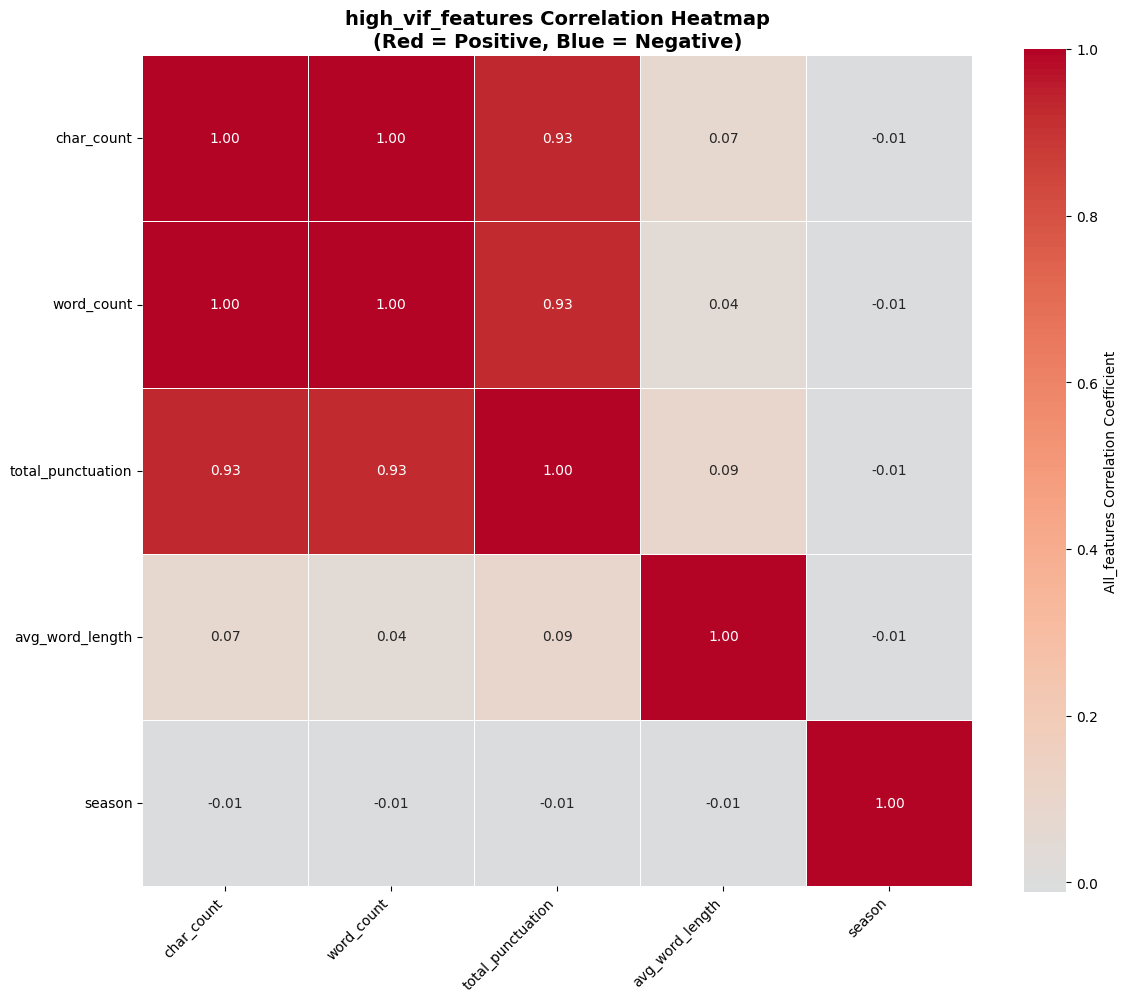

In [18]:
# 2.3.  Check for multicollinearity - VIF
high_vif_features = ['char_count', 'word_count', 'total_punctuation', 'avg_word_length', 'season']

corr_matrix = df[high_vif_features].corr()
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'All_features Correlation Coefficient'})

plt.title('high_vif_features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

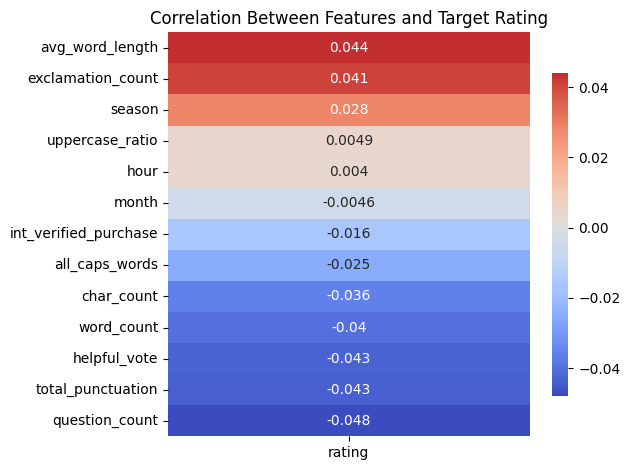

In [19]:
# 3. DESCENDING CORRELATION VISUALIZATION
corr_features_all = ["rating"] + features

corr_with_rating = df[corr_features_all].corr()[["rating"]].drop("rating").sort_values("rating", ascending=False)

sns.heatmap(
    corr_with_rating,
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Between Features and Target Rating")
plt.tight_layout()
# plt.savefig("correlation between target and (all) features_1.png")
plt.show()


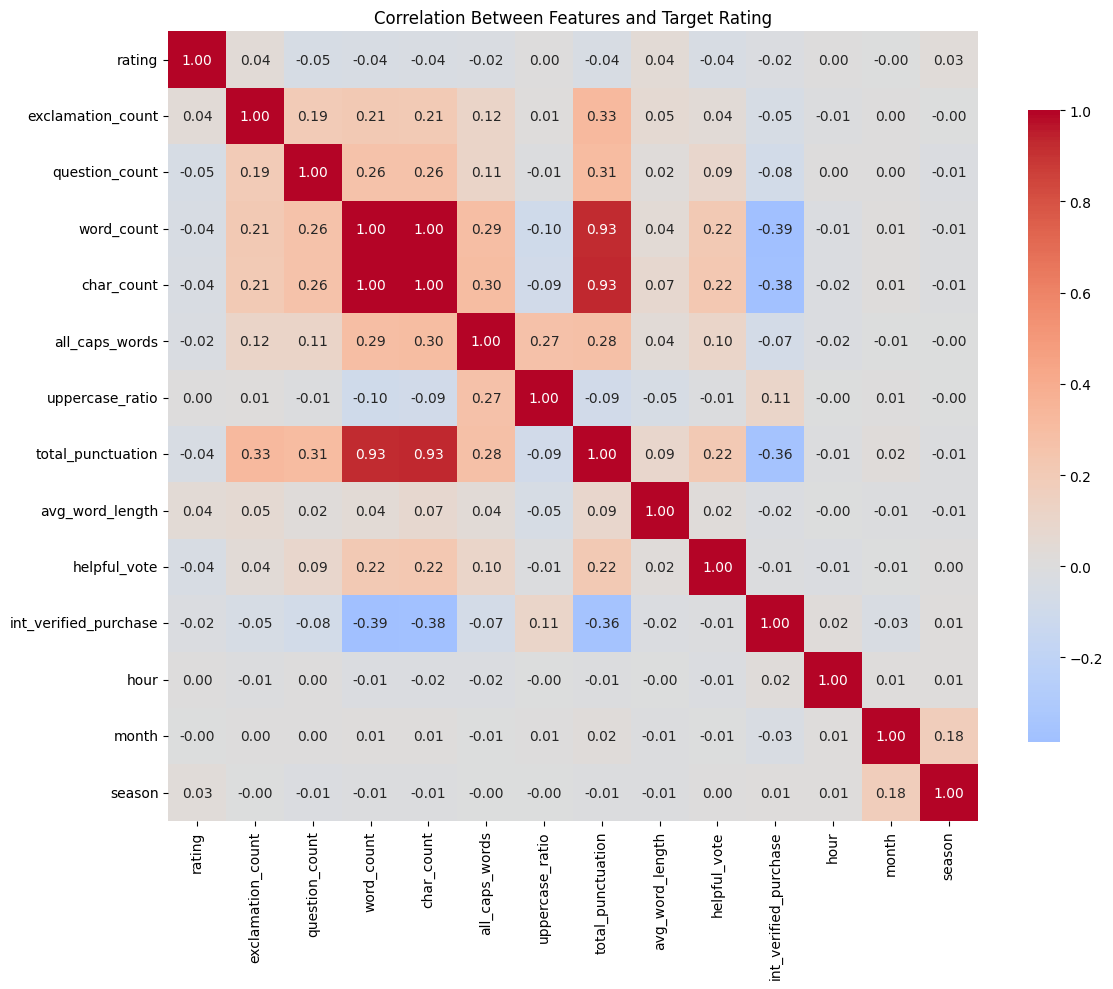

In [20]:
# 4. CORRELATION WITH TARGET FULL VISUALIZATION
corr_features_all = ["rating"] + features
plt.figure(figsize=(12, 10))
corr_with_rating = df[corr_features_all].corr()

sns.heatmap(
    corr_with_rating,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Between Features and Target Rating")
plt.tight_layout()
# plt.savefig("correlation between target and (all) features_2.png")
plt.show()


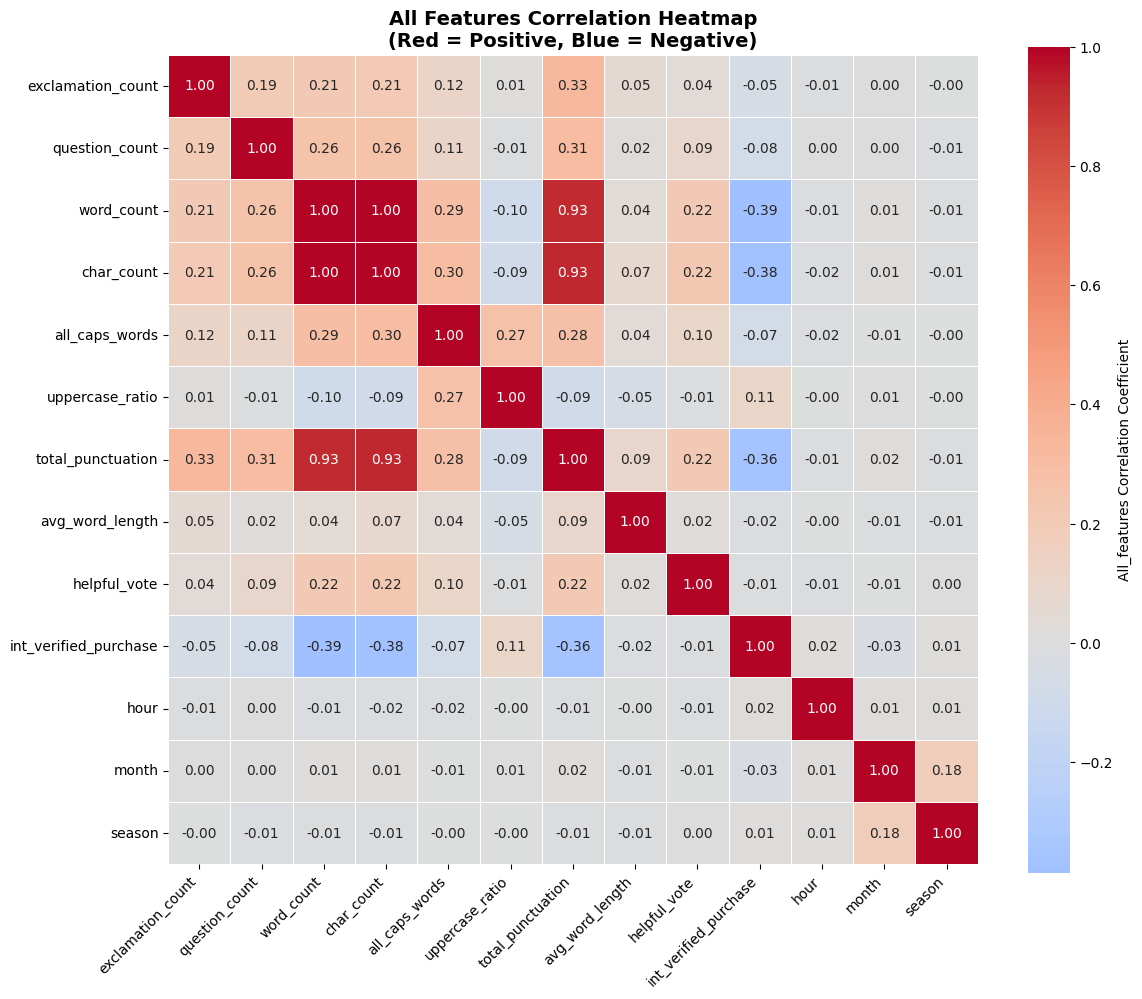

In [21]:
# 5. CORRELATION MATRIX BETWEEN ALL FEATURES
# Create correlation matrix
corr_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'All_features Correlation Coefficient'})

plt.title('All Features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the file
# plt.savefig("multicolinarity_heatmap_(all)features.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16949 entries, 0 to 16948
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   category               16949 non-null  object        
 1   rating                 16949 non-null  float64       
 2   tokens                 16949 non-null  object        
 3   text_cleaned           16949 non-null  object        
 4   original_text          16949 non-null  object        
 5   token_count            16949 non-null  int64         
 6   title                  16949 non-null  object        
 7   images                 16949 non-null  object        
 8   verified_purchase      16949 non-null  bool          
 9   asin                   16949 non-null  object        
 10  parent_asin            16949 non-null  object        
 11  user_id                16949 non-null  object        
 12  datetime               16949 non-null  datetime64[ns]
 13  h

In [23]:
# df.to_parquet('amazon_user_reviews_regular_ML.parquet', index=False)

In [24]:
simplified_col = ["rating"] + features
simplified_df = df[simplified_col]
simplified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16949 entries, 0 to 16948
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   rating                 16949 non-null  float64
 1   exclamation_count      16949 non-null  int64  
 2   question_count         16949 non-null  int64  
 3   word_count             16949 non-null  int64  
 4   char_count             16949 non-null  int64  
 5   all_caps_words         16949 non-null  int64  
 6   uppercase_ratio        16949 non-null  float64
 7   total_punctuation      16949 non-null  int64  
 8   avg_word_length        16949 non-null  float64
 9   helpful_vote           16949 non-null  int64  
 10  int_verified_purchase  16949 non-null  int64  
 11  hour                   16949 non-null  int32  
 12  month                  16949 non-null  int32  
 13  season                 16949 non-null  int64  
dtypes: float64(3), int32(2), int64(9)
memory usage: 1.7 MB

In [25]:
simplified_df.to_parquet('amazon_user_reviews_regular_ML_simplified.parquet', index=False)